In [2]:
import torch
from datasets import load_dataset
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from librosa import resample
from e2_tts_pytorch import E2TTS
from e2_tts_pytorch import DurationPredictor

tokenizer_object = Tokenizer.from_file("tokenizer.json")
fast_tokenizer_object = PreTrainedTokenizerFast(tokenizer_object=tokenizer_object)
def tokenizer(text):
    ids = fast_tokenizer_object(text, return_tensors="pt", padding=True).input_ids
    ids[ids == 0] = -1
    return ids

train_dataset = load_dataset("formospeech/hat_tts", "sixian", split="train")
train_dataset = train_dataset.rename_column("ipa", "transcript")
train_dataset = train_dataset.map(lambda x: {"transcript": x["transcript"].replace("-", "")}, num_proc=8)

ref_sample = train_dataset[0]
ref_wav = resample(ref_sample["audio"]["array"], orig_sr=ref_sample["audio"]["sampling_rate"], target_sr=24000)
ref_transcript = ref_sample["transcript"]


duration_predictor = DurationPredictor(
    transformer = dict(
        dim = 384,
        depth = 8,
        heads = 6,
    ),
    text_num_embeds = fast_tokenizer_object.vocab_size,
    tokenizer = tokenizer,
).to('cuda')

e2tts = E2TTS(
    duration_predictor = duration_predictor,
    cond_drop_prob = 0.2,
    transformer = dict(
        dim = 512,
        depth = 12,
        heads = 6,

    ),
    text_num_embeds = fast_tokenizer_object.vocab_size,
    tokenizer=tokenizer,
).to('cuda')



/mnt/md1/user_wayne/e2-tts-pytorch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/md1/user_wayne/e2-tts-pytorch/.venv/lib/python3.11/site-packages/vocos/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

In [3]:
ref_mel_spec = e2tts.mel_spec(torch.from_numpy(ref_wav).float().unsqueeze(0)).permute(0, 2, 1).cuda()

In [4]:
ckpt = torch.load('e2tts.pt')
e2tts.load_state_dict(ckpt['model_state_dict'], strict=False)
e2tts.eval()
duration_predictor_ckpt = torch.load('duration_predictor.pt')
duration_predictor.load_state_dict(duration_predictor_ckpt['model_state_dict'])
duration_predictor.eval()


/tmp/ipykernel_1732231/3680881591.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('e2tts.pt')
/tmp/ipykernel_1732231/3680881591.py:4: FutureWarning: Yo

DurationPredictor(
  (mel_spec): MelSpec(
    (mel_stft): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (transformer): Transformer(
    (abs_pos_emb): Embedding(8192, 384)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): ModuleList(
          (0): None
          (1): DepthwiseConv(
            (dw_conv1d): Sequential(
              (0): Conv1d(384, 384, kernel_size=(31,), stride=(1,), padding=(15,), groups=384)
              (1): SiLU()
            )
          )
          (2): RMSNorm()
          (3): Attention(
            (to_q): Linear(in_features=384, out_features=384, bias=False)
            (to_k): Linear(in_features=384, out_features=384, bias=False)
            (to_v): Linear(in_features=384, out_features=384, bias=False)
            (to_v_head_gate): Linear(in_features=384, out_features=6, bias=True)
            (attend): Attend(
              (attn_dropout): Dropout(p=0.1, inplace=False)
            )
         

In [9]:
with torch.inference_mode():
    # text = ref_transcript + " k u_24 i_24 tʰ i_11 a_11 u_11 l u_55 t i_55 a_55 u_55 t en_31 t͡sʰ oŋ_11 t͡sʰ oŋ_11 k e_55 f a_24 t en_24 <sil> kʰ i_11 kʰ i_11 u_11 f uŋ_24 tʰ i_11 a_11 u_11 i_31 s un_55 <sil> k u_24 i_24 v uk_2 h a_24 ŋ in_11 k e_55 ɕ im_24 ŋ i_55 en_55 <sil> t͡ɕʰ in_24 t͡ɕʰ i_55 oŋ_55 f a_24 t en_24 h a_24 s e_24 u_24 n on_24 k e_55 k oŋ_24 f a_11"
    # text = ref_transcript + " ku_24 i_24 tʰ i_11 a_11 u_11 l u_55 t i_55 a_55 u_55 t en_31 t͡sʰ oŋ_11 t͡sʰ oŋ_11 k e_55 f a_24 t en_24"
    
    # text = ref_transcript + "ku_24i_24tʰi_11a_11u_11lu_55 "
    text = ref_transcript + "sɨt_5fan_55 o_55i_55 t͡sɨn_55kin_24 sɨt_5"
    # text = ref_transcript +  train_dataset[1]["transcript"]

    targe_mel_spec = e2tts.mel_spec(torch.from_numpy(resample(train_dataset[1]["audio"]["array"], orig_sr=48000, target_sr=24000)).float().unsqueeze(0))
    print(fast_tokenizer_object.tokenize(text))
    print(ref_mel_spec.shape[1]+targe_mel_spec.shape[2])
    # text = e2tts.tokenizer([text]).cuda()
    # duration = duration_predictor()
    generated = e2tts.sample(
        cond = torch.from_numpy(ref_wav).float().unsqueeze(0).cuda(),
        text = [text],
        steps = 32,
        cfg_strength = 1.0,
        duration=222+74,
    )

['an_31', 't͡so', '_31 ', '<sil>', 'sɨ', 't_5', 'f', 'an_55 ', 'o_55i_55 ', 't͡sɨn', '_55', 'kin', '_24 ', 'sɨ', 't_5']
162


In [9]:
generated[0].shape
generated[0].shape[0] / 24000

4.256

In [5]:
print(torch.full((1,), ref_mel_spec.shape[1], dtype = torch.long).cuda())

tensor([74], device='cuda:0')


In [7]:
print(duration_predictor(ref_mel_spec.cuda(), text=[text], lens=torch.full((1,), ref_mel_spec.shape[1], dtype = torch.long).cuda(), return_loss=False))

tensor([222.7842], device='cuda:0', grad_fn=<ViewBackward0>)


In [8]:
from IPython.display import Audio 
from IPython.display import display
display(Audio(data=ref_wav,rate=24000, autoplay=True))
display(Audio(data=generated[0].cpu(),rate=24000, autoplay=True))


[Text(0.5, 1.0, 'Generated')]

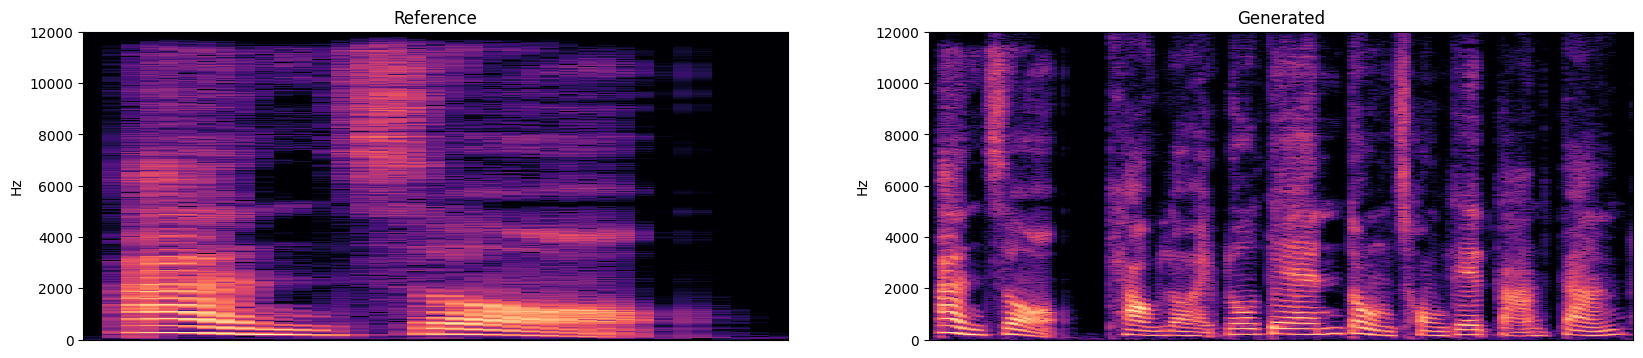

In [7]:
# show spectrogram in ipython
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
%matplotlib inline  

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(ref_wav)), ref=np.max), ax=ax[0], sr=24000, y_axis='linear')
ax[0].set(title='Reference')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(generated[0].cpu().numpy())), ref=np.max), ax=ax[1], sr=24000, y_axis='linear')
ax[1].set(title='Generated')


torch.Size([1, 74, 100])


ValueError: axes don't match array

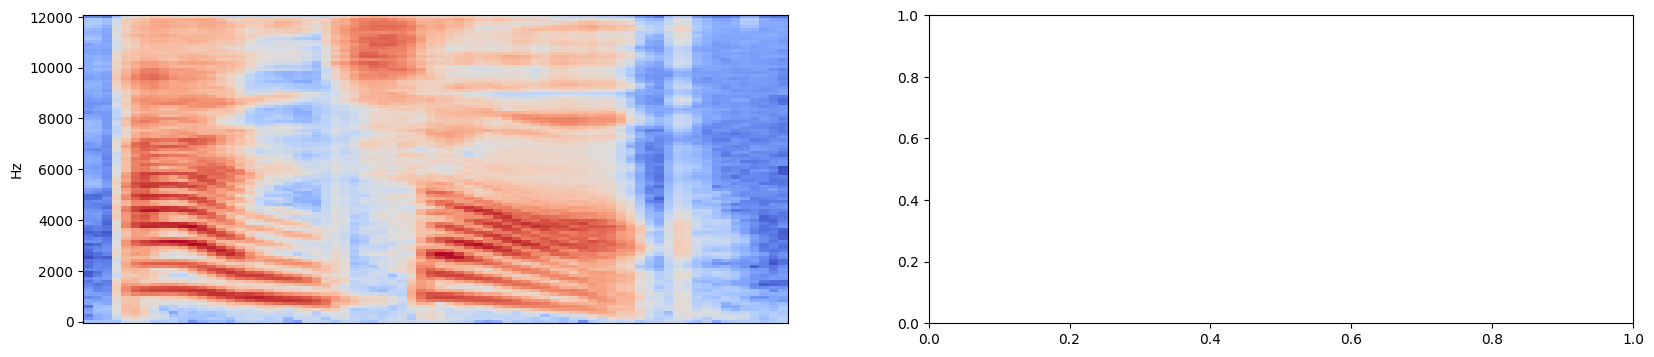

In [8]:
# show mel spec
from torchaudio.functional import DB_to_amplitude
mel = DB_to_amplitude(generated[0], ref = 1., power = 0.5).cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
print(ref_mel_spec.shape)
librosa.display.specshow(ref_mel_spec.squeeze(0).permute(1,0).cpu().numpy(), ax=ax[0], sr=24000, y_axis='linear')

librosa.display.specshow(mel.transpose(1,0), ax=ax[1], sr=24000, y_axis='linear')


In [16]:
from vocos import Vocos
import numpy as np


vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")

print(vocos.decode(ref_mel_spec.permute(0,2,1).cpu()))
display(Audio(data=e2tts.vocos.decode(ref_mel_spec.permute(0,2,1)).cpu(),rate=24000, autoplay=True))
display(Audio(data=e2tts.vocos.decode(torch.from_numpy(mel).unsqueeze(0).permute(0, 2, 1).cuda()).cpu(),rate=24000, autoplay=True))


tensor([[2.9170e-05, 1.6525e-04, 2.4526e-05,  ..., 3.5604e-04, 3.5500e-04,
         3.5658e-04]])


/mnt/md1/user_wayne/e2-tts-pytorch/.venv/lib/python3.11/site-packages/vocos/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_pat